# Tuning a scikit-learn pipeline with `skopt`

Katie Malone, July 2016

### Problem Statement

Scikit-learn objects (transformers, estimators) are often not used singly, but instead chained together into a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">pipeline</a>.  When that happens, there can be several different sets of hyperparameters to examine, one for each object.  In the same way that `GridSearchCV` can be applied to a pipeline to tune the hyperparameters of several objects at once, we can do a more efficient search (this example uses GPs) over more than one scikit-learn object.  

In this example, we expand upon the optimization in <a href="hyperparameter-optimization.ipynb">this notebook</a>--that example optimizes over the parameters of a single object, a classifier, but now we'll simultaneously optimize over the parameters of a PCA transformation and a decision tree classifier.

In [1]:
import numpy as np
import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

digits = sklearn.datasets.load_digits()
X = digits.data
y = digits.target

pca = PCA()
clf = DecisionTreeClassifier(random_state=42)
pipe = Pipeline([('pca', pca), ('clf', clf)])

### Defining the search space

Our parameter space has dimensions for the `n_components` parameter of PCA, as well as several parameters of the decision tree.  

Optionally, we can also define a starting point for the search.

In [2]:
space  = [(2,20),  # n_components of PCA
          (1, 5),  # max_depth of tree
          (2, 30), # min_samples_split of tree
          (1, 30)] # min_samples_leaf of tree

x0 = [5, 3, 2, 1]  # optional starting point

### Objective function

Our objective function is mean absolute error of our pipeline, which is found via a 5-fold cross validation procedure.  The two named steps of the pipeline, `pca` and `clf`, each are pulled out via their names for getting their parameters set.

In [3]:
from sklearn.cross_validation import cross_val_score
def objective(params):
    n_components, max_depth, min_samples_split, min_samples_leaf = params
    
    # set PCA n_components parameter
    pipe.set_params(pca__n_components=n_components)

    # set decision tree classifier parameters
    pipe.set_params(clf__max_depth=max_depth,
                   clf__max_features=n_components,
                   clf__min_samples_split=min_samples_split,
                   clf__min_samples_leaf=min_samples_leaf)

    error = -np.mean(cross_val_score(pipe, X, y, cv=5, n_jobs=-1, scoring="mean_absolute_error"))
    return error

/Users/civisemployee/src/scikit-optimize/src/sklearn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Search all the things!

In [4]:
from skopt import gp_minimize
import warnings
warnings.filterwarnings("ignore") # this minimize call issues a lot of warnings--quiet them
                                  # associated scikit-learn issue #6746

res_gp = gp_minimize(objective, space, x0=x0, n_calls=50, random_state=0)
print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - n_components=%d
    - max_depth=%d
    - min_samples_split=%d
    - min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                                res_gp.x[2], res_gp.x[3]))

Best score=1.3806
Best parameters:
    - n_components=3
    - max_depth=5
    - min_samples_split=18
    - min_samples_leaf=11


We've started with a gaussian process algorithm; now add dummy and forest minimization functions to get a 

In [6]:
from skopt import dummy_minimize
res_dummy = dummy_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

from skopt import forest_minimize
res_forest = forest_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

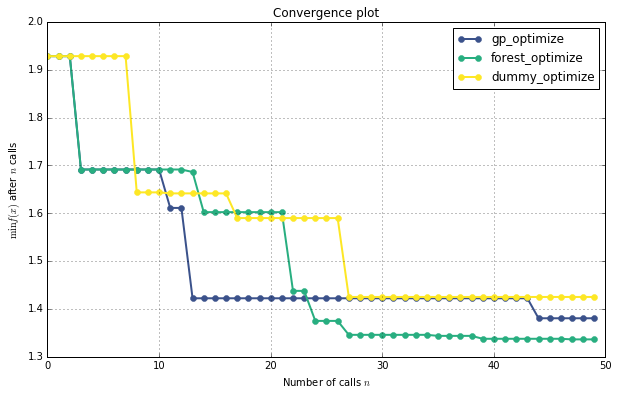

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

from skopt.plots import plot_convergence
plot_convergence(("gp_optimize", res_gp),
                 ("forest_optimize", res_forest),
                 ("dummy_optimize", res_dummy))